In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
def add(a: int, b: int) -> int:
    ''' Add a and b
    Args:
        a: int
        b: int
    Return:
        int
    '''
    return a + b

In [3]:
add(23,20)

43

In [4]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [5]:
arxiv.invoke("LLM for cybersecurity")

'Published: 2024-12-04\nTitle: When LLMs Meet Cybersecurity: A Systematic Literature Review\nAuthors: Jie Zhang, Haoyu Bu, Hui Wen, Yongji Liu, Haiqiang Fei, Rongrong Xi, Lun Li, Yun Yang, Hongsong Zhu, Dan Meng\nSummary: The rapid development of large language models (LLMs) has opened new avenues\nacross various fields, including cybersecurity, which faces an evolving threat\nlandscape and demand for innovative technologies. Despite initial explorations\ninto the application of LLMs in cybersecurity, '

In [6]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [7]:
wiki.invoke("What is pen testing")

"Page: Penetration test\nSummary: A penetration test, colloquially known as a pentest, is an authorized simulated cyberattack on a computer system, performed to evaluate the security of the system; this is not to be confused with a vulnerability assessment. The test is performed to identify weaknesses (or vulnerabilities), including the potential for unauthorized parties to gain access to the system's features and data, as well as strengths, enabling a full risk assessment to be completed.\nThe pro"

In [8]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [9]:
tools=[wiki,arxiv,add]

In [10]:
from langchain_groq import ChatGroq
groq=ChatGroq(model="qwen-qwq-32b")
groq.invoke("What is testing")

AIMessage(content='\n<think>\nOkay, the user is asking "What is testing". I need to explain it clearly. Let me start by defining testing in general terms. Testing is a process to evaluate something, right? It\'s used in different fields like software, education, manufacturing.\n\nFirst, maybe break it down by areas. In software testing, it\'s to find bugs and ensure quality. I should mention different types like unit, integration, system testing. Also, why it\'s important—like catching issues before release to prevent failures.\n\nThen in education, tests assess knowledge. Like exams, quizzes. Maybe note standardized tests like SATs. But also formative vs summative assessments.\n\nManufacturing and quality control: testing products to meet standards, maybe destructive vs non-destructive testing. Safety and reliability.\n\nScience experiments: testing hypotheses. Controlled experiments, variables, data analysis. Important for validating theories.\n\nMedical testing: diagnostics, blood t

In [11]:
llm_with_tools = groq.bind_tools(tools)
llm_with_tools.invoke("Reaserch on cybersecurity")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'k7wftx9dh', 'function': {'arguments': '{"query":"cybersecurity"}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': '20azp28q0', 'function': {'arguments': '{"query":"cybersecurity"}', 'name': 'arxiv'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 309, 'prompt_tokens': 264, 'total_tokens': 573, 'completion_time': 0.714332656, 'prompt_time': 0.017207977, 'queue_time': 0.263736643, 'total_time': 0.731540633}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a91d9c2cfb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5f30837c-15ab-4faa-8997-5a9795a7620d-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'cybersecurity'}, 'id': 'k7wftx9dh', 'type': 'tool_call'}, {'name': 'arxiv', 'args': {'query': 'cybersecurity'}, 'id': '20azp28q0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 264, 'output_tokens': 309, 'total_tokens': 573})

In [12]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [13]:
def chatbot(state: State):
    return {"messages":llm_with_tools.invoke(state["messages"])}

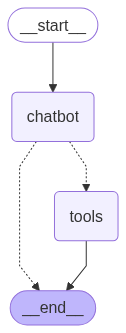

In [14]:
from IPython.display import Image
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.messages import HumanMessage

graph = StateGraph(State)
graph.add_node(
    "chatbot",
    chatbot
)
graph.add_node(
    "tools",
    ToolNode(tools)
)

graph.add_edge(START,"chatbot")
graph.add_conditional_edges("chatbot",tools_condition)
graph_builder = graph.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [15]:
messages=graph_builder.invoke({"messages":HumanMessage(content="What is your opinion on automaing cybersecurity")})

In [16]:
from pprint import pprint
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is your opinion on automaing cybersecurity
================================== Ai Message ==================================
Tool Calls:
  wikipedia (qawwwzf79)
 Call ID: qawwwzf79
  Args:
    query: Automated cybersecurity
  arxiv (vcjgzhwa7)
 Call ID: vcjgzhwa7
  Args:
    query: automation in cybersecurity
================================= Tool Message =================================
Name: wikipedia

Page: Pentera
Summary: Pentera is an American cybersecurity software company, specializing in automated security validation solutions. Originally founded as Pcysys in 2015, the company later rebranded as Pentera in 2021. The company is led by Amitai Ratzon (CEO) and Dr. Arik Liberzon (founder and CTO). Pentera has entities in the US, Germany, UK, Israel, Dubai, and Singapore.


================================= Tool Message =================================
Name: arxiv

Published: 2024-12-31
Title: C

## ReAct Agent Archicture
ReAct stands for Reasoning and Acting.
It allows LLMs to:

Reason through a problem step-by-step (like Chain-of-Thought).

Act by interacting with tools (e.g., a calculator, search engine, API) when needed.

Observe the result of those actions.

Continue reasoning or acting based on observations.


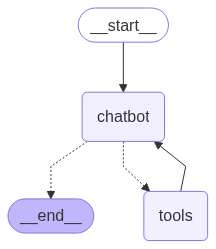

In [17]:
react = StateGraph(State)
react.add_node(
    "chatbot",
    chatbot
)

react.add_node(
    "tools",
    ToolNode(tools)
)

react.add_edge(START,"chatbot")
react.add_conditional_edges("chatbot",tools_condition)
react.add_edge("tools","chatbot")
react_builder = react.compile()
display(Image(react_builder.get_graph().draw_mermaid_png()))

In [18]:
react_messages=react_builder.invoke({"messages":HumanMessage(content="what is the values of the addition of 60 and 40")})
for message in react_messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is the values of the addition of 60 and 40
================================== Ai Message ==================================
Tool Calls:
  add (h36xp5n8e)
 Call ID: h36xp5n8e
  Args:
    a: 60
    b: 40
================================= Tool Message =================================
Name: add

100
================================== Ai Message ==================================

The result of adding 60 and 40 is **100**.


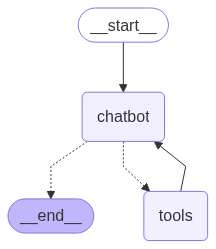

In [19]:
from langgraph.checkpoint.memory import MemorySaver

checkPoint = MemorySaver()
react_builder = react.compile(checkpointer=checkPoint)

display(Image(react_builder.get_graph().draw_mermaid_png()))

In [20]:
config={"configurable":{"thread_id":1}}

messages=react_builder.invoke({"messages":HumanMessage(content="what is the values of the addition of 60 and 40")},config=config)
for message in messages["messages"]:    
    message.pretty_print()

================================ Human Message =================================

what is the values of the addition of 60 and 40
================================== Ai Message ==================================
Tool Calls:
  add (qg6mqcxmn)
 Call ID: qg6mqcxmn
  Args:
    a: 60
    b: 40
================================= Tool Message =================================
Name: add

100
================================== Ai Message ==================================

The result of adding 60 and 40 is **100**.


In [21]:
messages=react_builder.invoke({"messages":HumanMessage(content="What are the mutiples of the result")},config=config)
for message in messages["messages"]:    
    message.pretty_print()

================================ Human Message =================================

what is the values of the addition of 60 and 40
================================== Ai Message ==================================
Tool Calls:
  add (qg6mqcxmn)
 Call ID: qg6mqcxmn
  Args:
    a: 60
    b: 40
================================= Tool Message =================================
Name: add

100
================================== Ai Message ==================================

The result of adding 60 and 40 is **100**.
================================ Human Message =================================

What are the mutiples of the result
================================== Ai Message ==================================

The multiples of 100 are numbers like 100, 200, 300, 400, and so on, obtained by multiplying 100 by any integer (1, 2, 3, ...). Let me know if you'd like to explore further!


## streaming
values : Returns the full state of graph
Updates : Updates to the state of the graph (Latest message)

In [27]:
config={"configurable":{"thread_id":2}}

for chunk in react_builder.stream({"messages":HumanMessage(content="Hi,Iam Jaya,Iam interested in Cybersecurity")},config=config,stream_mode="values"):
    print(chunk)


{'messages': [HumanMessage(content='what is the values of the addition of 60 and 40', additional_kwargs={}, response_metadata={}, id='e327f01b-9256-4be8-9f73-94c9086efd6f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'vdt2g5at2', 'function': {'arguments': '{"a":60,"b":40}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 167, 'prompt_tokens': 274, 'total_tokens': 441, 'completion_time': 0.383420012, 'prompt_time': 0.017909386, 'queue_time': 0.45462565899999996, 'total_time': 0.401329398}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_18a313a21d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--36ecd3a5-93ab-4eea-889b-cc34cf958b78-0', tool_calls=[{'name': 'add', 'args': {'a': 60, 'b': 40}, 'id': 'vdt2g5at2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 274, 'output_tokens': 167, 'total_tokens': 441}), HumanMessage(content='what is the values of the addition of 60 and 40', additional_kwargs=

In [29]:
config={"configurable":{"thread_id":2}} ##create thread

async for chunk in react_builder.astream_events({"messages":HumanMessage(content="Hi,Iam Jaya,Iam interested in Cybersecurity")},config=config,stream_mode="updates"):
    print(chunk)


{'event': 'on_chain_start', 'data': {'input': {'messages': HumanMessage(content='Hi,Iam Jaya,Iam interested in Cybersecurity', additional_kwargs={}, response_metadata={})}}, 'name': 'LangGraph', 'tags': [], 'run_id': '95a6dfe5-c0cd-4380-a3d4-75ffed211a97', 'metadata': {'thread_id': 2}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='what is the values of the addition of 60 and 40', additional_kwargs={}, response_metadata={}, id='e327f01b-9256-4be8-9f73-94c9086efd6f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'vdt2g5at2', 'function': {'arguments': '{"a":60,"b":40}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 167, 'prompt_tokens': 274, 'total_tokens': 441, 'completion_time': 0.383420012, 'prompt_time': 0.017909386, 'queue_time': 0.45462565899999996, 'total_time': 0.401329398}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_18a313a21d', 'finish_reason': 't